# Imports

In [1]:
import pandas as pd
import psycopg2

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap

# Conect to db

In [2]:
# Define our connection string
conn_string = "host='localhost' port='5432' dbname='GTA' user='jcostamagna'"

# print the connection string we will use to connect
print ("Connecting to database\n	->")

# get a connection, if a connect cannot be made an exception will be raised here
conn = psycopg2.connect(conn_string)

# conn.cursor will return a cursor object, you can use this cursor to perform queries
cursor = conn.cursor()
print( "Connected!\n" )

#cursor.execute('SELECT * FROM  public."GTA_DataView";')

Connecting to database
	->
Connected!



# Create dataframes

In [3]:
cursor.execute('SELECT time, idsession, scenario,' +
               ' MAX(CASE data_type_id WHEN 1 THEN value END) as posX,' +
               'MAX(CASE data_type_id WHEN 2 THEN value END) as posY,' +
               ' MAX(CASE data_type_id WHEN 10 THEN value END) as hadCollision,'+
               ' MAX(CASE data_type_id WHEN 17 THEN value END) as pedId,'+
               ' MAX(CASE data_type_id WHEN 15 THEN value END) as nextPedRunning,'+
               ' MAX(CASE data_type_id WHEN 11 THEN value END) as distancePed,'+
                ' MAX(CASE data_type_id WHEN 8 THEN value END) as speed,'+
                ' MAX(CASE data_type_id WHEN 12 THEN value END) as posPedX,'+
                ' MAX(CASE data_type_id WHEN 13 THEN value END) as posPedY,'+
               ' MAX(CASE data_type_id WHEN 596 THEN value END) as currentDistance'+
               ' FROM datagta gta WHERE gta.idsession >= 144 AND gta.data_type_id in (1,2,8,10,11,12,13,15,17,596)'+
               ' AND gta.idsession not in (145,146,147,148,149,151,155,158,162,164)'+
               ' GROUP BY time, idsession, scenario;')
rows = cursor.fetchall()
timestamps = [row[0] for row in rows]
if (len(timestamps) == 0):
    print ("Something went wrong")
firstTime = timestamps[:1][0]
lastTime = timestamps[-1:][0]
dfGTA = pd.DataFrame(rows, index=timestamps)
#dfDiffGTA = dfGTA.diff()
dfGTA.columns=['time','session_id','scenario', 'Pos_X', 'Pos_Y', 'hadCollision', 'pedId', 'nextPedRunning', 'distancePed','speed', 'posPedX', 'posPedY' , 'currentDistance']

In [4]:
cursor.execute('SELECT time, idsession, scenario,' +
               ' MAX(CASE data_type_id WHEN 1 THEN value END) as Steering,' +
               'MAX(CASE data_type_id WHEN 2 THEN value END) as Brake,' +
               ' MAX(CASE data_type_id WHEN 3 THEN value END) as Throttle '+
               ' FROM datasteering gta WHERE gta.idsession >= 144 AND gta.data_type_id in (1,2,3)'+
               ' AND gta.idsession not in (145,146,147,148,149,151,155,158,162,164) '+
               ' GROUP BY time, idsession, scenario;')
rows = cursor.fetchall()
timestamps = [row[0] for row in rows]
df_steer = pd.DataFrame(rows, index=timestamps)
df_steer.columns=['time2','session_id','scenario', 'steering', 'brake',  'throttle']
freq_resample = '50000U'
df_steer = df_steer.resample(freq_resample).ffill()
freq_resample = '50000U'
dfGTA = dfGTA.resample(freq_resample).ffill()
steer = df_steer.drop(df_steer.columns[[1, 2]], axis=1)
df_joined = pd.concat([dfGTA, steer], axis=1, join='inner')

In [5]:
#pedCross = dfGTA[(dfGTA.nextPedRunning == True) & (dfGTA.distancePed < 20)  & (dfGTA.scenario != 7) & (dfGTA.scenario != 8)]
#df_joined['acceleration'] = df_joined['speed'].diff()
df_joined = df_joined[~df_joined.index.duplicated()]
df_joined.head()

,time,session_id,scenario,Pos_X,Pos_Y,hadCollision,pedId,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance,time2,steering,brake,throttle
2017-10-04 12:46:18.050,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-10-04 12:46:18.048674,33096.0,65535.0,65535.0
2017-10-04 12:46:18.100,2017-10-04 12:46:18.071232,144.0,7.0,-975.7495,82.24962,0.0,17.0,0.0,70.352844,0.0,154.0415,-23.48739,1253.50293,2017-10-04 12:46:18.088780,33096.0,65535.0,65535.0
2017-10-04 12:46:18.150,2017-10-04 12:46:18.071232,144.0,7.0,-975.7495,82.24962,0.0,17.0,0.0,70.352844,0.0,154.0415,-23.48739,1253.50293,2017-10-04 12:46:18.148940,33096.0,65535.0,65535.0
2017-10-04 12:46:18.200,2017-10-04 12:46:18.071232,144.0,7.0,-975.7495,82.24962,0.0,17.0,0.0,70.352844,0.0,154.0415,-23.48739,1253.50293,2017-10-04 12:46:18.188544,33096.0,65535.0,65535.0
2017-10-04 12:46:18.250,2017-10-04 12:46:18.071232,144.0,7.0,-975.7495,82.24962,0.0,17.0,0.0,70.352844,0.0,154.0415,-23.48739,1253.50293,2017-10-04 12:46:18.248732,33096.0,65535.0,65535.0


# Backup Csv

In [6]:
data = pd.read_csv("DataJoined.csv", index_col=0) 
data = data.dropna()

In [7]:
df_joined = data.copy()
df_joined = df_joined[(df_joined.pedId != 16)  & (df_joined.pedId != 17)  & (df_joined.speed > 0)  & (df_joined.scenario != 7) & (df_joined.scenario != 8)]
df_joined.head()

,time,session_id,scenario,Pos_X,Pos_Y,hadCollision,pedId,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance,time.1,steering,brake,throttle
2017-10-04 12:50:28.400,2017-10-04 12:50:28.383484,144.0,1.0,-975.703700,82.260376,0.0,1.0,0.0,89.979675,0.013278,-885.6892,70.21315,1253.45900,2017-10-04 12:50:28.384988,32307.0,65535.0,65535.0
2017-10-04 12:50:28.450,2017-10-04 12:50:28.437127,144.0,1.0,-975.709534,82.251080,0.0,1.0,0.0,89.984790,0.135856,-885.6892,70.21315,1253.46400,2017-10-04 12:50:28.444647,32307.0,65535.0,65535.0
2017-10-04 12:50:28.500,2017-10-04 12:50:28.494279,144.0,1.0,-975.714233,82.246090,0.0,1.0,0.0,89.988880,0.125762,-885.6892,70.21315,1253.46814,2017-10-04 12:50:28.484754,32307.0,65535.0,65535.0
2017-10-04 12:50:28.550,2017-10-04 12:50:28.520850,144.0,1.0,-975.716000,82.244156,0.0,1.0,0.0,89.990330,0.102796,-885.6892,70.21315,1253.46960,2017-10-04 12:50:28.544914,32307.0,65535.0,65535.0
2017-10-04 12:50:28.600,2017-10-04 12:50:28.584519,144.0,1.0,-975.718100,82.241540,0.0,1.0,0.0,89.991715,0.047856,-885.6892,70.21315,1253.47168,2017-10-04 12:50:28.585020,32307.0,65535.0,65535.0


## Clean Data

In [8]:
df_joined['steering'] = df_joined['steering'].divide(65535)
df_joined['brake'] = df_joined['brake'].divide(65535)
df_joined['throttle'] = df_joined['throttle'].divide(65535)
df_joined['acceleration'] = df_joined['speed'].diff()
df_joined = df_joined[(df_joined.pedId != 16)  & (df_joined.pedId != 17)  & (df_joined.speed > 0)  & (df_joined.scenario != 7) & (df_joined.scenario != 8)]

# Means fields

In [9]:
means = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).mean()
#clean the ones in which didnt run the pedestrian
means = means[means.nextPedRunning != 0]
means_cleaned = means.drop(means.columns[[3,4,6,7,9,10,11]], axis=1)

#means_cleaned = means.dropna(thresh=11)
#df_joined = df_joined[df_joined.notnull()]
#session_id	scenario	pedId	hadCollision speed		steering	brake	throttle	acceleration
##means_cleaned['hadCollision'] = np.where(means_cleaned['hadCollision'] == 0, False, True)

#means_cleaned.drop(means_cleaned[means_cleaned.nextPedRunning == 0])
means_cleaned.head()

,session_id,scenario,pedId,hadCollision,speed,steering,brake,throttle,acceleration
0,144.0,1.0,1.0,0.000000,5.919151,0.503649,0.965743,0.820576,0.030731
1,144.0,1.0,3.0,0.000000,7.580378,0.499771,0.891302,0.878839,-0.026652
2,144.0,1.0,15.0,0.008366,9.474048,0.494557,0.952182,0.781126,0.006292
3,144.0,2.0,0.0,0.000000,3.398595,0.523305,0.960227,0.858795,0.027363
4,144.0,2.0,2.0,0.000000,11.669419,0.500661,0.891913,0.522365,0.008028


In [10]:
means_cleaned.shape

(655, 9)

In [11]:
#Rows in which the pedestrian didnt run
means[means.nextPedRunning == 0]

,session_id,scenario,pedId,Pos_X,Pos_Y,hadCollision,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance,steering,brake,throttle,acceleration


# Variances

In [12]:
variance = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).var()
variance_cleaned = variance.drop(variance.columns[[3,4,5,6,7,9,10,11]], axis=1)
#variance_cleaned['hadCollision'] = np.where(variance_cleaned['hadCollision'] == 0, False, True)
variance_cleaned.head()

,session_id,scenario,pedId,speed,steering,brake,throttle,acceleration
0,144.0,1.0,1.0,13.796202,0.000655,0.014468,0.028719,0.039370
1,144.0,1.0,3.0,31.451253,0.000345,0.058767,0.010391,0.063480
2,144.0,1.0,15.0,53.873833,0.001231,0.022506,0.045416,0.106281
3,144.0,2.0,0.0,5.036717,0.000101,0.018643,0.075860,0.027735
4,144.0,2.0,2.0,47.209285,0.000396,0.055982,0.112551,0.159198


In [13]:
variance_cleaned.shape

(671, 8)

# Between start, run and crash

## Total time

In [14]:
first = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
last = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).last()


In [15]:
total_time = first[['session_id', 'scenario', 'pedId']].copy()
first['timeFinal'] = last['time']
total_time['total_time'] = (pd.to_datetime(first['timeFinal']) - pd.to_datetime(first['time'])).dt.total_seconds()
#plt.plot(first['total_time'])
#s.dt.total_seconds()
total_time.head()


,session_id,scenario,pedId,total_time
0,144.0,1.0,1.0,15.405173
1,144.0,1.0,3.0,11.412381
2,144.0,1.0,15.0,102.356492
3,144.0,2.0,0.0,14.315100
4,144.0,2.0,2.0,7.505478


## Initial distance

In [16]:
initial_distance = first[['session_id', 'scenario', 'pedId', 'distancePed']].copy()
initial_distance.head()
## desconfianza con el index 2 y su tiempo
#144.0	1.0	15.0

#testing_distance = df_joined[(df_joined.pedId == 15)  & (df_joined.scenario == 1)  & (df_joined.session_id == 144) ]
#plt.plot(testing_distance['distancePed'])


,session_id,scenario,pedId,distancePed
0,144.0,1.0,1.0,89.979675
1,144.0,1.0,3.0,11.443494
2,144.0,1.0,15.0,10.211066
3,144.0,2.0,0.0,47.977978
4,144.0,2.0,2.0,3.084074


In [17]:
max_values = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).max()
initial_distance = max_values[['session_id', 'scenario', 'pedId', 'distancePed']].copy()
initial_distance.head()

,session_id,scenario,pedId,distancePed
0,144.0,1.0,1.0,89.992450
1,144.0,1.0,3.0,85.063860
2,144.0,1.0,15.0,789.212800
3,144.0,2.0,0.0,47.977978
4,144.0,2.0,2.0,88.011610


## Max Speed

In [18]:
max_speed = max_values[['session_id', 'scenario', 'pedId', 'speed']].copy()
max_speed.head()

,session_id,scenario,pedId,speed
0,144.0,1.0,1.0,11.669766
1,144.0,1.0,3.0,13.499710
2,144.0,1.0,15.0,25.851397
3,144.0,2.0,0.0,10.266865
4,144.0,2.0,2.0,20.055070


In [19]:
max_speed.shape

(671, 4)

## Before pedestrian crossed

In [20]:
def delete_unused_columns(df):
    df.drop('Pos_X', axis=1, inplace=True, errors='ignore') 
    df.drop('Pos_Y', axis=1, inplace=True, errors='ignore') 
    df.drop('distancePed', axis=1, inplace=True, errors='ignore') 
    df.drop('nextPedRunning', axis=1, inplace=True, errors='ignore') 
    df.drop('posPedX', axis=1, inplace=True, errors='ignore') 
    df.drop('posPedY', axis=1, inplace=True, errors='ignore') 
    df.drop('currentDistance', axis=1, inplace=True, errors='ignore') 
    df.drop('hadCollision', axis=1, inplace=True, errors='ignore') 

In [21]:
pedDidNotCross = df_joined[(df_joined.nextPedRunning == False)]
firstRowPedDidNotCross = pedDidNotCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
lastRowPedDidNotCross = pedDidNotCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).last()
meansPedDidNotCross = pedDidNotCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).mean()
varPedDidNotCross = pedDidNotCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).var()
delete_unused_columns(meansPedDidNotCross)
delete_unused_columns(varPedDidNotCross)


In [22]:
meansPedDidNotCross.shape

(652, 8)

In [23]:
meansPedDidNotCross[meansPedDidNotCross.isnull().values == True]

,session_id,scenario,pedId,speed,steering,brake,throttle,acceleration


In [24]:
varPedDidNotCross = varPedDidNotCross.dropna()
varPedDidNotCross.shape

(648, 8)

In [25]:
varPedDidNotCross[varPedDidNotCross.isnull().values == True]

,session_id,scenario,pedId,speed,steering,brake,throttle,acceleration


### Total time before run

In [26]:
beforePedCross = firstRowPedDidNotCross[['session_id', 'scenario', 'pedId']].copy()
firstRowPedDidNotCross['timeFinal'] = lastRowPedDidNotCross['time']
beforePedCross['total_time_before_run'] = (pd.to_datetime(firstRowPedDidNotCross['timeFinal']) - pd.to_datetime(firstRowPedDidNotCross['time'])).dt.total_seconds()
beforePedCross.head()
beforePedCross.shape

(652, 4)

In [27]:
beforePedCrossMerge = pd.merge(varPedDidNotCross, meansPedDidNotCross , on=['session_id','scenario','pedId'],how='left',suffixes=('_before_var','_before_mean'))
delete_unused_columns(beforePedCrossMerge)
beforePedCrossMerge.shape

(648, 13)

In [28]:
beforePedCrossTotalColumns = pd.merge(beforePedCrossMerge, beforePedCross , on=['session_id','scenario','pedId'],how='left')
beforePedCrossTotalColumns.head()

,session_id,scenario,pedId,speed_before_var,steering_before_var,brake_before_var,throttle_before_var,acceleration_before_var,speed_before_mean,steering_before_mean,brake_before_mean,throttle_before_mean,acceleration_before_mean,total_time_before_run
0,144.0,1.0,1.0,13.894033,0.000338,0.000000,0.017802,0.016136,6.614995,0.517642,1.000000,0.863178,0.038096,10.091857
1,144.0,1.0,3.0,1.185339,0.000238,0.000000,0.013602,0.004440,12.405217,0.481101,1.000000,0.772151,0.054448,3.673778
2,144.0,1.0,15.0,54.290571,0.001118,0.009412,0.045813,0.032457,9.719554,0.496611,0.969863,0.788247,0.013562,94.469000
3,144.0,2.0,0.0,4.118861,0.000045,0.020263,0.014640,0.019610,3.134071,0.525620,0.956432,0.933556,0.000010,13.052240
4,144.0,2.0,2.0,6.272065,0.000233,0.000000,0.094616,0.011947,15.771787,0.492397,1.000000,0.310690,0.178377,2.488626


In [29]:
beforePedCrossTotalColumns.shape

(648, 14)

## When pedestrian is running

In [30]:
pedCross = df_joined[(df_joined.nextPedRunning == True)]

In [31]:
firstRowPedCross = pedCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
lastRowPedCross = pedCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).last()
meansPedCross = pedCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).mean()
varPedCross = pedCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).var()
delete_unused_columns(meansPedCross)
delete_unused_columns(varPedCross)

### Total time when running

In [32]:
whenPedCross = firstRowPedCross[['session_id', 'scenario', 'pedId']].copy()
firstRowPedCross['timeFinal'] = lastRowPedCross['time']
whenPedCross['total_time_when_running'] = (pd.to_datetime(firstRowPedCross['timeFinal']) - pd.to_datetime(firstRowPedCross['time'])).dt.total_seconds()
whenPedCross.head()

,session_id,scenario,pedId,total_time_when_running
0,144.0,1.0,1.0,5.239119
1,144.0,1.0,3.0,7.705014
2,144.0,1.0,15.0,7.848389
3,144.0,2.0,0.0,1.202199
4,144.0,2.0,2.0,4.975241


In [33]:
whenPedCrossMerge = pd.merge(varPedCross, meansPedCross , on=['session_id','scenario','pedId'],how='left',suffixes=('_when_running_var','_when_running_mean'))
delete_unused_columns(whenPedCrossMerge)
whenPedCrossTotalColumns = pd.merge(whenPedCrossMerge, whenPedCross , on=['session_id','scenario','pedId'],how='left')
whenPedCrossTotalColumns.head()


,session_id,scenario,pedId,speed_when_running_var,steering_when_running_var,brake_when_running_var,throttle_when_running_var,acceleration_when_running_var,speed_when_running_mean,steering_when_running_mean,brake_when_running_mean,throttle_when_running_mean,acceleration_when_running_mean,total_time_when_running
0,144.0,1.0,1.0,11.033679,0.000174,0.035741,0.039745,0.083699,4.593110,0.476982,0.900460,0.739390,0.016767,5.239119
1,144.0,1.0,3.0,29.475829,0.000151,0.078618,0.000856,0.087210,5.276907,0.508684,0.839408,0.929774,-0.065371,7.705014
2,144.0,1.0,15.0,42.756716,0.001915,0.121984,0.035585,0.869046,6.933534,0.473303,0.769213,0.707442,-0.068940,7.848389
3,144.0,2.0,0.0,6.459006,0.000048,0.000000,0.044336,0.023489,6.170808,0.499042,1.000000,0.075305,0.314027,1.202199
4,144.0,2.0,2.0,55.270252,0.000429,0.075733,0.087892,0.212602,9.577210,0.504876,0.836788,0.630319,-0.078850,4.975241


In [34]:
whenPedCrossTotalColumns.shape

(655, 14)

In [35]:
whenPedCrossTotalColumns.isnull().values.any()

False

### Break Reaction Time

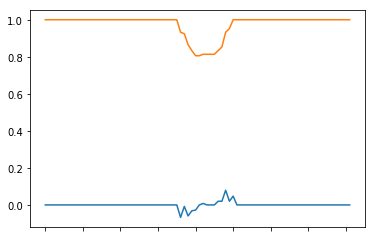

In [36]:
df_joined['brakeDiff'] = df_joined['brake'].diff()
pedCross = df_joined[(df_joined.nextPedRunning == True)]
dfNew = pedCross[(pedCross.session_id == 175.0) & (pedCross.scenario == 6.0) & (pedCross.pedId == 1.0)]
dfNew['brakeDiff'].plot()
dfNew['brake'].plot()

In [37]:
startReactionBrake = pedCross
finishReactionBrake = pedCross[(pedCross.brakeDiff < 0)]
finishReactionBrake.shape

(6536, 19)

In [38]:
firstRowPedCross = startReactionBrake.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
firstRowPressBrake = finishReactionBrake.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
firstRowPressBrake.shape
firstRowPedCross.shape

(655, 19)

In [39]:
reactionBrake = pd.merge(firstRowPedCross, firstRowPressBrake, on=['session_id','scenario','pedId'],how='left',suffixes=('_init','_fin'))
reactionBrake.head()

,session_id,scenario,pedId,time_init,Pos_X_init,Pos_Y_init,hadCollision_init,nextPedRunning_init,distancePed_init,speed_init,...,speed_fin,posPedX_fin,posPedY_fin,currentDistance_fin,time.1_fin,steering_fin,brake_fin,throttle_fin,acceleration_fin,brakeDiff_fin
0,144.0,1.0,1.0,2017-10-04 12:50:38.549538,-909.306458,80.473330,0.0,1.0,23.562530,7.754880,...,8.946986,-885.665649,72.027790,1178.73486,2017-10-04 12:50:39.586297,0.477104,0.980163,0.948409,0.072344,-0.019837
1,144.0,1.0,3.0,2017-10-04 12:50:47.530114,-839.965700,83.164460,0.0,1.0,39.895280,13.472353,...,13.034663,-801.989441,93.251990,1094.34827,2017-10-04 12:50:49.648762,0.533089,0.980163,0.948409,-0.009284,-0.019837
2,144.0,1.0,15.0,2017-10-04 12:52:29.782335,-62.199753,40.680523,0.0,1.0,49.374313,25.585112,...,25.720684,-20.775450,15.126913,355.46260,2017-10-04 12:52:29.893130,0.504952,0.900801,0.445304,0.069757,-0.099199
3,144.0,2.0,0.0,2017-10-04 12:57:42.500777,-933.749300,84.487495,0.0,1.0,7.474411,2.517837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,144.0,2.0,2.0,2017-10-04 12:57:46.323453,-885.836365,77.199104,0.0,1.0,49.291360,19.412086,...,19.944923,-836.171631,80.316110,1141.20886,2017-10-04 12:57:47.485545,0.480339,0.964294,0.932540,-0.081133,-0.035706


In [40]:
reactionPressBrake = firstRowPedCross[['session_id', 'scenario', 'pedId', 'speed']].copy()
reactionPressBrake['reaction_time'] = (pd.to_datetime(reactionBrake['time_fin']) - pd.to_datetime(reactionBrake['time_init']))
reactionPressBrake.head()

,session_id,scenario,pedId,speed,reaction_time
0,144.0,1.0,1.0,7.754880,00:00:01.048791
1,144.0,1.0,3.0,13.472353,00:00:02.106615
2,144.0,1.0,15.0,25.585112,00:00:00.079211
3,144.0,2.0,0.0,2.517837,NaT
4,144.0,2.0,2.0,19.412086,00:00:01.161592


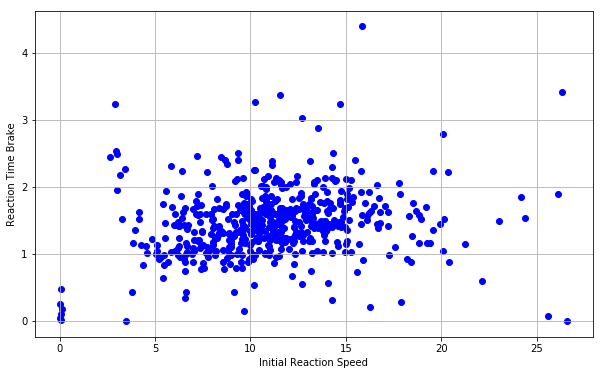

In [41]:
plt.figure(figsize=(10, 6))
plt.xlabel("Initial Reaction Speed")
plt.ylabel("Reaction Time Brake")
reactionPressBrake = reactionPressBrake[reactionPressBrake.reaction_time.dt.total_seconds() < 50]

noHits = plt.scatter(reactionPressBrake['speed'], reactionPressBrake['reaction_time'].dt.total_seconds(), marker='o', c='b')

plt.grid(True)

plt.show()

# Merge dataframes

In [42]:
df_suffix = pd.merge(means_cleaned, variance_cleaned, on=['session_id','scenario','pedId'],how='left',suffixes=('_total_mean','_total_var'))
df_suffix = pd.merge(df_suffix, total_time, on=['session_id','scenario','pedId'],how='left')
df_suffix = pd.merge(df_suffix, initial_distance, on=['session_id','scenario','pedId'],how='left')
df_suffix = pd.merge(df_suffix, max_speed, on=['session_id','scenario','pedId'],how='left',suffixes=('','_max'))
#df_suffix = pd.merge(df_suffix, beforePedCrossTotalColumns, on=['session_id','scenario','pedId'],how='right')
#df_suffix = pd.merge(df_suffix, whenPedCrossTotalColumns, on=['session_id','scenario','pedId'],how='inner')
df_suffix.head()

,session_id,scenario,pedId,hadCollision,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,total_time,distancePed,speed
0,144.0,1.0,1.0,0.000000,5.919151,0.503649,0.965743,0.820576,0.030731,13.796202,0.000655,0.014468,0.028719,0.039370,15.405173,89.992450,11.669766
1,144.0,1.0,3.0,0.000000,7.580378,0.499771,0.891302,0.878839,-0.026652,31.451253,0.000345,0.058767,0.010391,0.063480,11.412381,85.063860,13.499710
2,144.0,1.0,15.0,0.008366,9.474048,0.494557,0.952182,0.781126,0.006292,53.873833,0.001231,0.022506,0.045416,0.106281,102.356492,789.212800,25.851397
3,144.0,2.0,0.0,0.000000,3.398595,0.523305,0.960227,0.858795,0.027363,5.036717,0.000101,0.018643,0.075860,0.027735,14.315100,47.977978,10.266865
4,144.0,2.0,2.0,0.000000,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,0.000396,0.055982,0.112551,0.159198,7.505478,88.011610,20.055070


In [49]:
def delete_common_columns(df):
    df.drop('session_id', axis=1, inplace=True, errors='ignore') 
    df.drop('pedId', axis=1, inplace=True, errors='ignore')

delete_common_columns(df_suffix)
df_scenario_cluster = df_suffix.copy()
df_suffix.drop('scenario', axis=1, inplace=True, errors='ignore') 
df_suffix.rename(columns={'speed':'max_speed'}, inplace=True)


In [50]:
df_suffix.isnull().values.any()

False

In [51]:
df_suffix.shape

(655, 14)

In [52]:
def plot_corr(df, size=11):
    """
    Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot

    Displays:
        matrix of correlation between columns.  Blue-cyan-yellow-red-darkred => less to more correlated
                                                0 ------------------>  1
                                                Expect a darkred line running from top left to bottom right
    """

    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks

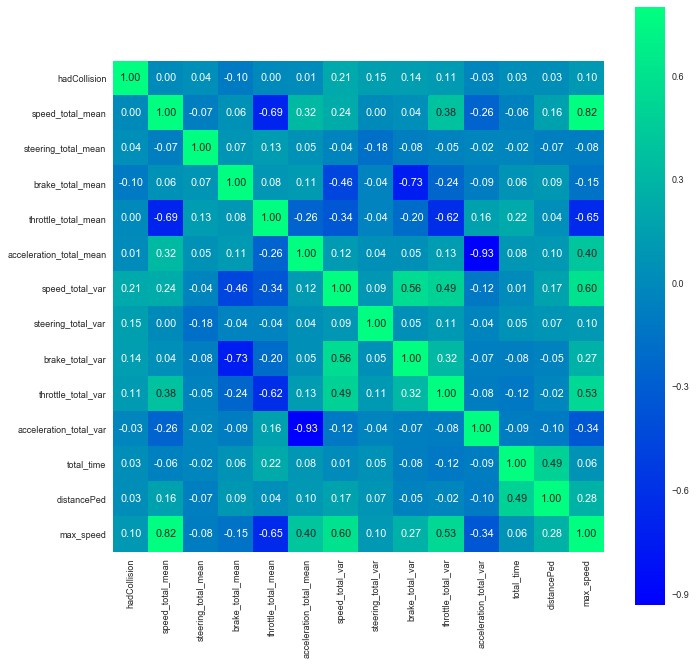

In [53]:
import seaborn as sns

corrmat = df_suffix.corr()
f, ax = plt.subplots(figsize=(11,11))
sns.set(font_scale=0.9)
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f', cmap="winter")
plt.show()

In [48]:
df_suffix.corr()

,hadCollision,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,total_time,distancePed,speed
hadCollision,1.000000,0.003023,0.037162,-0.103735,0.000472,0.011156,0.212230,0.147238,0.143651,0.113680,-0.025400,0.031473,0.032134,0.097091
speed_total_mean,0.003023,1.000000,-0.073901,0.057452,-0.691672,0.320063,0.236173,0.001821,0.038165,0.382434,-0.258142,-0.056937,0.163800,0.821473
steering_total_mean,0.037162,-0.073901,1.000000,0.073249,0.129062,0.052155,-0.036002,-0.178203,-0.075838,-0.047182,-0.022899,-0.022556,-0.071290,-0.080720
brake_total_mean,-0.103735,0.057452,0.073249,1.000000,0.083151,0.111709,-0.464997,-0.039894,-0.731555,-0.239204,-0.085719,0.064027,0.092040,-0.148294
throttle_total_mean,0.000472,-0.691672,0.129062,0.083151,1.000000,-0.262172,-0.339819,-0.039581,-0.197457,-0.620655,0.160891,0.222875,0.040787,-0.652242
acceleration_total_mean,0.011156,0.320063,0.052155,0.111709,-0.262172,1.000000,0.116663,0.044029,0.047181,0.128485,-0.932188,0.084147,0.101619,0.404565
speed_total_var,0.212230,0.236173,-0.036002,-0.464997,-0.339819,0.116663,1.000000,0.088946,0.556514,0.490132,-0.118702,0.012359,0.165060,0.602346
steering_total_var,0.147238,0.001821,-0.178203,-0.039894,-0.039581,0.044029,0.088946,1.000000,0.045281,0.105340,-0.036567,0.053497,0.071798,0.097545
brake_total_var,0.143651,0.038165,-0.075838,-0.731555,-0.197457,0.047181,0.556514,0.045281,1.000000,0.318190,-0.072101,-0.075732,-0.049071,0.267796
throttle_total_var,0.113680,0.382434,-0.047182,-0.239204,-0.620655,0.128485,0.490132,0.105340,0.318190,1.000000,-0.082509,-0.115168,-0.022477,0.533691


## Mold Data

### Data Types

Inspect data types to see if there are any issues.  Data should be numeric.

In [54]:
df = df_suffix
#hadCollision_map = {True : 1, False : 0}
df['hadCollision'] = np.where(df['hadCollision'] == 0, 0, 1)

In [55]:

cols_at_end = ['hadCollision']
df = df[[c for c in df if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df]]
df.head(5)

,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,total_time,distancePed,max_speed,hadCollision
0,5.919151,0.503649,0.965743,0.820576,0.030731,13.796202,0.000655,0.014468,0.028719,0.039370,15.405173,89.992450,11.669766,0
1,7.580378,0.499771,0.891302,0.878839,-0.026652,31.451253,0.000345,0.058767,0.010391,0.063480,11.412381,85.063860,13.499710,0
2,9.474048,0.494557,0.952182,0.781126,0.006292,53.873833,0.001231,0.022506,0.045416,0.106281,102.356492,789.212800,25.851397,1
3,3.398595,0.523305,0.960227,0.858795,0.027363,5.036717,0.000101,0.018643,0.075860,0.027735,14.315100,47.977978,10.266865,0
4,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,0.000396,0.055982,0.112551,0.159198,7.505478,88.011610,20.055070,0


### Backup merge data

In [58]:
#df.to_csv('mergeData.csv', index=False)

### Distribution

In [144]:
num_obs = len(df)
num_true = len(df.loc[df['hadCollision'] == 1])
num_false = len(df.loc[df['hadCollision'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  61 (9.31%)
Number of False cases: 594 (90.69%)


### Spliting the data

70% for training, 30% for testing

In [145]:
from sklearn.model_selection import train_test_split

predicted_column = ['hadCollision']

feature_col_names = [c for c in df if c not in predicted_column]
predicted_class_names = predicted_column

X = df[feature_col_names].values     # predictor feature columns (10 X m)
y = df[predicted_class_names].values # predicted class (1=true, 0=false) column (1 X m)
split_test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=42) 
                            # test_size = 0.3 is 30%, 42 is the answer to everything

We check to ensure we have the the desired 70% train, 30% test split of the data

In [146]:
print("{0:0.2f}% in training set".format((len(X_train)/len(df.index)) * 100))
print("{0:0.2f}% in test set".format((len(X_test)/len(df.index)) * 100))

69.92% in training set
30.08% in test set


#### Verifying predicted value was split correctly

In [147]:
print("Original True  : {0} ({1:0.2f}%)".format(len(df.loc[df['hadCollision'] == 1]), (len(df.loc[df['hadCollision'] == 1])/len(df.index)) * 100.0))
print("Original False : {0} ({1:0.2f}%)".format(len(df.loc[df['hadCollision'] == 0]), (len(df.loc[df['hadCollision'] == 0])/len(df.index)) * 100.0))
print("")
print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
print("")
print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))

Original True  : 61 (9.31%)
Original False : 594 (90.69%)

Training True  : 48 (10.48%)
Training False : 410 (89.52%)

Test True      : 13 (6.60%)
Test False     : 184 (93.40%)


### Post-split Data Preparation

In [148]:
df.head()

,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,...,brake_when_running_var,throttle_when_running_var,acceleration_when_running_var,speed_when_running_mean,steering_when_running_mean,brake_when_running_mean,throttle_when_running_mean,acceleration_when_running_mean,total_time_when_running,hadCollision
0,5.919151,0.503649,0.965743,0.820576,0.030731,13.796202,0.000655,0.014468,0.028719,0.039370,...,0.035741,0.039745,0.083699,4.593110,0.476982,0.900460,0.739390,0.016767,5.239119,0
1,7.580378,0.499771,0.891302,0.878839,-0.026652,31.451253,0.000345,0.058767,0.010391,0.063480,...,0.078618,0.000856,0.087210,5.276907,0.508684,0.839408,0.929774,-0.065371,7.705014,0
2,9.474048,0.494557,0.952182,0.781126,0.006292,53.873833,0.001231,0.022506,0.045416,0.106281,...,0.121984,0.035585,0.869046,6.933534,0.473303,0.769213,0.707442,-0.068940,7.848389,1
3,3.398595,0.523305,0.960227,0.858795,0.027363,5.036717,0.000101,0.018643,0.075860,0.027735,...,0.000000,0.044336,0.023489,6.170808,0.499042,1.000000,0.075305,0.314027,1.202199,0
4,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,0.000396,0.055982,0.112551,0.159198,...,0.075733,0.087892,0.212602,9.577210,0.504876,0.836788,0.630319,-0.078850,4.975241,0


# Training Initial Algorithm

## Naive Bayes

In [149]:
from sklearn.naive_bayes import GaussianNB

# create Gaussian Naive Bayes model object and train it with the data
nb_model = GaussianNB()

nb_model.fit(X_train, y_train.ravel())

GaussianNB(priors=None)

### Performance on Training Data

In [150]:
# predict values using the training data
nb_predict_train = nb_model.predict(X_train)

# import the performance metrics library
from sklearn import metrics

# Accuracy
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_train, nb_predict_train)))
print()

Accuracy: 0.6004



### Performance on Testing Data

In [151]:
# predict values using the testing data
nb_predict_test = nb_model.predict(X_test)

from sklearn import metrics

# training metrics
print("nb_predict_test", nb_predict_test)
#print ("y_test", y_test)
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, nb_predict_test)))

nb_predict_test [0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1
 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1
 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0
 1 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1
 0 0 0 1 0 1 0 0 0 0 0 1]
Accuracy: 0.6091


#### Metrics

In [152]:
print("Confusion Matrix")
print("{0}".format(metrics.confusion_matrix(y_test, nb_predict_test)))
print("")

print("Classification Report")
print(metrics.classification_report(y_test, nb_predict_test))

Confusion Matrix
[[112  72]
 [  5   8]]

Classification Report
             precision    recall  f1-score   support

          0       0.96      0.61      0.74       184
          1       0.10      0.62      0.17        13

avg / total       0.90      0.61      0.71       197



## Random Forest

In [153]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=10)      # Create random forest object
rf_model.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Predict Training Data

In [154]:
rf_predict_train = rf_model.predict(X_train)
# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_train, rf_predict_train)))

Accuracy: 0.9869


### Predict Test Data

In [155]:
rf_predict_test = rf_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, rf_predict_test)))

Accuracy: 0.9289


In [156]:
print(metrics.confusion_matrix(y_test, rf_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, rf_predict_test))

## TN  FP
## FN  TP

[[183   1]
 [ 13   0]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       184
          1       0.00      0.00      0.00        13

avg / total       0.87      0.93      0.90       197



## Logistic Regression

In [157]:
from sklearn.linear_model import LogisticRegression

#lr_model =LogisticRegression(C=0.7, random_state=42, solver='liblinear', max_iter=10000)
lr_model =LogisticRegression(C=0.7, random_state=42)
lr_model.fit(X_train, y_train.ravel())
lr_predict_test = lr_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_predict_test)))
print(metrics.confusion_matrix(y_test, lr_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_predict_test))

Accuracy: 0.9442
[[183   1]
 [ 10   3]]

Classification Report
             precision    recall  f1-score   support

          0       0.95      0.99      0.97       184
          1       0.75      0.23      0.35        13

avg / total       0.94      0.94      0.93       197



1st max value of 0.231 occured at C=0.100


Text(0,0.5,'recall score')

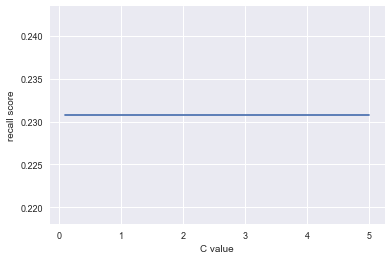

In [158]:
C_start = 0.1
C_end = 5
C_inc = 0.1

C_values, recall_scores = [], []

C_val = C_start
best_recall_score = 0
while (C_val < C_end):
    C_values.append(C_val)
    lr_model_loop = LogisticRegression(C=C_val, random_state=42, solver='liblinear')
    lr_model_loop.fit(X_train, y_train.ravel())
    lr_predict_loop_test = lr_model_loop.predict(X_test)
    recall_score = metrics.recall_score(y_test, lr_predict_loop_test)
    recall_scores.append(recall_score)
    if (recall_score > best_recall_score):
        best_recall_score = recall_score
        best_lr_predict_test = lr_predict_loop_test
        
    C_val = C_val + C_inc

best_score_C_val = C_values[recall_scores.index(best_recall_score)]
print("1st max value of {0:.3f} occured at C={1:.3f}".format(best_recall_score, best_score_C_val))

%matplotlib inline 
plt.plot(C_values, recall_scores, "-")
plt.xlabel("C value")
plt.ylabel("recall score")

### Logisitic regression with class_weight='balanced'

1st max value of 0.538 occured at C=0.900


Text(0,0.5,'recall score')

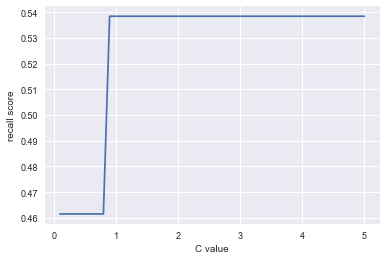

In [159]:
C_start = 0.1
C_end = 5
C_inc = 0.1

C_values, recall_scores = [], []

C_val = C_start
best_recall_score = 0
while (C_val < C_end):
    C_values.append(C_val)
    lr_model_loop = LogisticRegression(C=C_val, class_weight="balanced", random_state=42, solver='liblinear', max_iter=10000)
    lr_model_loop.fit(X_train, y_train.ravel())
    lr_predict_loop_test = lr_model_loop.predict(X_test)
    recall_score = metrics.recall_score(y_test, lr_predict_loop_test)
    recall_scores.append(recall_score)
    if (recall_score > best_recall_score):
        best_recall_score = recall_score
        best_lr_predict_test = lr_predict_loop_test
        
    C_val = C_val + C_inc

best_score_C_val = C_values[recall_scores.index(best_recall_score)]
print("1st max value of {0:.3f} occured at C={1:.3f}".format(best_recall_score, best_score_C_val))

%matplotlib inline 
plt.plot(C_values, recall_scores, "-")
plt.xlabel("C value")
plt.ylabel("recall score")

In [160]:
from sklearn.linear_model import LogisticRegression
lr_model =LogisticRegression( class_weight="balanced", C=best_score_C_val, random_state=42, solver='liblinear')
lr_model.fit(X_train, y_train.ravel())
lr_predict_test = lr_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_predict_test)))
print(metrics.confusion_matrix(y_test, lr_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_predict_test))
print(metrics.recall_score(y_test, lr_predict_test))

Accuracy: 0.6853
[[128  56]
 [  6   7]]

Classification Report
             precision    recall  f1-score   support

          0       0.96      0.70      0.81       184
          1       0.11      0.54      0.18        13

avg / total       0.90      0.69      0.76       197

0.5384615384615384


### LogisticRegressionCV

In [161]:
from sklearn.linear_model import LogisticRegressionCV
lr_cv_model = LogisticRegressionCV(n_jobs=-1, random_state=42, Cs=3, cv=10, refit=False, class_weight="balanced", max_iter=500)  # set number of jobs to -1 which uses all cores to parallelize
lr_cv_model.fit(X_train, y_train.ravel())

LogisticRegressionCV(Cs=3, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=500,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
           refit=False, scoring=None, solver='lbfgs', tol=0.0001,
           verbose=0)

### Predict on Test data

In [162]:
lr_cv_predict_test = lr_cv_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_cv_predict_test)))
print(metrics.confusion_matrix(y_test, lr_cv_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_cv_predict_test))

Accuracy: 0.8071
[[152  32]
 [  6   7]]

Classification Report
             precision    recall  f1-score   support

          0       0.96      0.83      0.89       184
          1       0.18      0.54      0.27        13

avg / total       0.91      0.81      0.85       197



### Linear SVC

In [163]:
from sklearn.model_selection import train_test_split

data = df.copy()
X = data.drop('hadCollision', axis=1) 
Y = data['hadCollision']

from sklearn import preprocessing
X = preprocessing.scale(X)


X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [164]:
from sklearn.svm import LinearSVC

clf_svc = LinearSVC(penalty='l1', dual=False, tol=1e-3)
clf_svc.fit(X_train, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)

In [165]:
print(clf_svc.score(x_test, y_test))

0.916030534351145


In [166]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5, whiten=True)
X_reduced = pca.fit_transform(X)

In [167]:
pca.explained_variance_

array([6.09179704, 4.19158511, 2.90060492, 2.01183001, 1.73962064])

In [168]:
pca.explained_variance_ratio_

array([0.25343736, 0.17438274, 0.12067402, 0.08369827, 0.07237353])

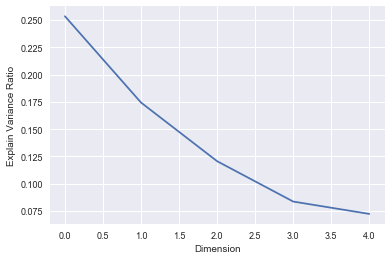

In [169]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Dimension')
plt.ylabel('Explain Variance Ratio')
plt.show()
#Scree plot

In [170]:
X_train, x_test, Y_train, y_test = train_test_split(X_reduced, Y, test_size=0.2, random_state=0)
clf_svc = LinearSVC(penalty='l1', dual=False, tol=1e-3)
clf_svc.fit(X_train, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)

In [171]:
print(clf_svc.score(x_test, y_test))

0.9083969465648855


#### Cluster from scenarios

In [172]:
df_scenario_cluster.head()

,scenario,hadCollision,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,...,steering_when_running_var,brake_when_running_var,throttle_when_running_var,acceleration_when_running_var,speed_when_running_mean,steering_when_running_mean,brake_when_running_mean,throttle_when_running_mean,acceleration_when_running_mean,total_time_when_running
0,1.0,0.000000,5.919151,0.503649,0.965743,0.820576,0.030731,13.796202,0.000655,0.014468,...,0.000174,0.035741,0.039745,0.083699,4.593110,0.476982,0.900460,0.739390,0.016767,5.239119
1,1.0,0.000000,7.580378,0.499771,0.891302,0.878839,-0.026652,31.451253,0.000345,0.058767,...,0.000151,0.078618,0.000856,0.087210,5.276907,0.508684,0.839408,0.929774,-0.065371,7.705014
2,1.0,0.008366,9.474048,0.494557,0.952182,0.781126,0.006292,53.873833,0.001231,0.022506,...,0.001915,0.121984,0.035585,0.869046,6.933534,0.473303,0.769213,0.707442,-0.068940,7.848389
3,2.0,0.000000,3.398595,0.523305,0.960227,0.858795,0.027363,5.036717,0.000101,0.018643,...,0.000048,0.000000,0.044336,0.023489,6.170808,0.499042,1.000000,0.075305,0.314027,1.202199
4,2.0,0.000000,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,0.000396,0.055982,...,0.000429,0.075733,0.087892,0.212602,9.577210,0.504876,0.836788,0.630319,-0.078850,4.975241


In [173]:
from sklearn.model_selection import train_test_split

data = df_scenario_cluster.copy()
X = data.drop('scenario', axis=1) 
Y = data['scenario']

from sklearn import preprocessing
X = preprocessing.scale(X)


X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [174]:
from sklearn.svm import LinearSVC

clf_svc = LinearSVC(penalty='l1', dual=False, tol=1e-3)
clf_svc.fit(X_train, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)

In [175]:
print(clf_svc.score(x_test, y_test))

0.4351145038167939


In [176]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5, whiten=True)
X_reduced = pca.fit_transform(X)

In [177]:
pca.explained_variance_

array([6.10683356, 4.20528569, 2.90596682, 2.02242817, 1.74126031])

In [178]:
pca.explained_variance_ratio_

array([0.24390041, 0.16795462, 0.11606121, 0.08077362, 0.06954408])

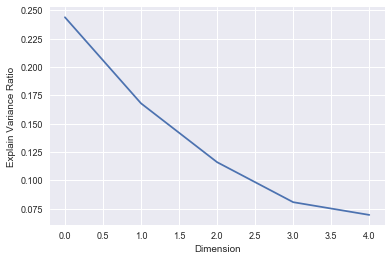

In [179]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Dimension')
plt.ylabel('Explain Variance Ratio')
plt.show()

In [180]:
X_train, x_test, Y_train, y_test = train_test_split(X_reduced, Y, test_size=0.2, random_state=0)
clf_svc = LinearSVC(penalty='l1', dual=False, tol=1e-3)
clf_svc.fit(X_train, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)

In [181]:
print(clf_svc.score(x_test, y_test))

0.29770992366412213


### MeanShift

In [182]:
from sklearn.cluster import MeanShift
dataFrame = df.copy()

analyzer = MeanShift(bandwidth=70)
analyzer.fit(dataFrame)

MeanShift(bandwidth=70, bin_seeding=False, cluster_all=True, min_bin_freq=1,
     n_jobs=1, seeds=None)

In [183]:
from sklearn.cluster import estimate_bandwidth

estimate_bandwidth(dataFrame)

80.26694790703168

In [184]:
labels = analyzer.labels_

In [185]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6])

In [186]:
dataFrame['cluster_group'] = np.nan
data_length = len(dataFrame)
for i in range(data_length):
    dataFrame.iloc[i, dataFrame.columns.get_loc('cluster_group')] = labels[i]

In [187]:
dataFrame.head()

,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,...,throttle_when_running_var,acceleration_when_running_var,speed_when_running_mean,steering_when_running_mean,brake_when_running_mean,throttle_when_running_mean,acceleration_when_running_mean,total_time_when_running,hadCollision,cluster_group
0,5.919151,0.503649,0.965743,0.820576,0.030731,13.796202,0.000655,0.014468,0.028719,0.039370,...,0.039745,0.083699,4.593110,0.476982,0.900460,0.739390,0.016767,5.239119,0,0.0
1,7.580378,0.499771,0.891302,0.878839,-0.026652,31.451253,0.000345,0.058767,0.010391,0.063480,...,0.000856,0.087210,5.276907,0.508684,0.839408,0.929774,-0.065371,7.705014,0,0.0
2,9.474048,0.494557,0.952182,0.781126,0.006292,53.873833,0.001231,0.022506,0.045416,0.106281,...,0.035585,0.869046,6.933534,0.473303,0.769213,0.707442,-0.068940,7.848389,1,2.0
3,3.398595,0.523305,0.960227,0.858795,0.027363,5.036717,0.000101,0.018643,0.075860,0.027735,...,0.044336,0.023489,6.170808,0.499042,1.000000,0.075305,0.314027,1.202199,0,0.0
4,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,0.000396,0.055982,0.112551,0.159198,...,0.087892,0.212602,9.577210,0.504876,0.836788,0.630319,-0.078850,4.975241,0,0.0


In [188]:
dataFrame.describe()

,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,...,throttle_when_running_var,acceleration_when_running_var,speed_when_running_mean,steering_when_running_mean,brake_when_running_mean,throttle_when_running_mean,acceleration_when_running_mean,total_time_when_running,hadCollision,cluster_group
count,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,...,655.000000,6.550000e+02,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000
mean,7.987191,0.502204,0.959427,0.812115,-0.020020,15.369249,0.000927,0.018102,0.032908,0.273928,...,0.035769,2.562516e-01,7.291854,0.501457,0.924892,0.808358,-0.044074,10.767179,0.093130,0.247328
std,3.740045,0.010688,0.052920,0.126159,0.153846,13.677285,0.002787,0.027826,0.037133,1.551995,...,0.041068,1.531710e+00,4.108181,0.015147,0.082771,0.143912,0.155841,31.374280,0.290836,0.748018
min,0.015117,0.418696,0.441398,0.199416,-1.779510,0.000251,0.000000,0.000000,0.000000,0.000007,...,0.000000,1.663293e-07,0.015117,0.385388,0.441398,0.075305,-1.779510,0.150901,0.000000,0.000000
25%,5.757110,0.497913,0.944744,0.771546,-0.008199,7.271839,0.000078,0.000966,0.011291,0.021014,...,0.009976,2.505745e-02,4.883573,0.496080,0.887307,0.757800,-0.052260,4.152824,0.000000,0.000000
50%,7.474806,0.501098,0.975665,0.831697,0.000143,12.569265,0.000304,0.005730,0.020177,0.037177,...,0.021740,5.581903e-02,6.459509,0.500045,0.953593,0.835322,-0.025605,5.155710,0.000000,0.000000
75%,9.599790,0.505841,0.991609,0.883929,0.008954,19.953399,0.000662,0.024807,0.039857,0.074261,...,0.044298,1.002668e-01,8.786491,0.505914,0.985116,0.896792,-0.002892,6.358851,0.000000,0.000000
max,35.358340,0.561057,1.000000,1.000000,0.171440,124.624108,0.037609,0.200328,0.226159,19.011509,...,0.232309,1.901151e+01,36.319434,0.589599,1.000000,1.000000,0.314027,344.235341,1.000000,6.000000


In [189]:
dataFrameCluster = dataFrame.groupby(['cluster_group']).mean()
dataFrameCluster

,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,...,brake_when_running_var,throttle_when_running_var,acceleration_when_running_var,speed_when_running_mean,steering_when_running_mean,brake_when_running_mean,throttle_when_running_mean,acceleration_when_running_mean,total_time_when_running,hadCollision
cluster_group,,,,,,,,,,,,,,,,,,,,,
0.0,7.887470,0.502157,0.958623,0.806904,-0.022963,14.705734,0.000879,0.018488,0.033597,0.307975,...,0.030969,0.035905,0.280664,7.277498,0.501614,0.926740,0.809789,-0.049503,5.630962,0.077465
1.0,8.825458,0.503529,0.963621,0.818967,0.003037,21.534679,0.001373,0.019832,0.030851,0.032106,...,0.047379,0.034138,0.080932,7.647502,0.500095,0.905508,0.767292,-0.008089,6.032106,0.181818
2.0,9.232445,0.499030,0.976546,0.837564,0.001770,22.508241,0.001884,0.010716,0.028988,0.027321,...,0.049719,0.048340,0.123751,7.410295,0.495831,0.897335,0.732501,-0.000749,6.589248,0.272727
3.0,7.572369,0.502950,0.974084,0.910601,-0.011341,12.586728,0.000204,0.007492,0.024185,0.095436,...,0.009590,0.025079,0.083352,6.738427,0.504081,0.966015,0.935004,-0.021705,201.165259,0.000000
4.0,9.322995,0.508132,0.909123,0.895185,-0.014790,16.368998,0.000609,0.021577,0.025884,0.175735,...,0.023818,0.023126,0.171621,8.424250,0.512584,0.893861,0.919901,-0.014631,79.213483,0.166667
5.0,2.641436,0.499082,0.933273,0.974126,-0.002999,6.484751,0.000026,0.019491,0.002310,0.150991,...,0.021568,0.003742,0.012650,2.570975,0.501220,0.910892,0.968243,-0.004881,9.074812,1.000000
6.0,3.072536,0.497784,0.992410,0.969904,-0.003625,2.967740,0.000033,0.000902,0.004328,0.033197,...,0.000006,0.000267,0.017874,2.312557,0.495784,0.999638,0.995387,-0.003943,344.235341,1.000000


In [190]:
dataFrameCluster['Counts'] = pd.Series(dataFrame.groupby(['cluster_group']).size())
dataFrameCluster

,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,...,throttle_when_running_var,acceleration_when_running_var,speed_when_running_mean,steering_when_running_mean,brake_when_running_mean,throttle_when_running_mean,acceleration_when_running_mean,total_time_when_running,hadCollision,Counts
cluster_group,,,,,,,,,,,,,,,,,,,,,
0.0,7.887470,0.502157,0.958623,0.806904,-0.022963,14.705734,0.000879,0.018488,0.033597,0.307975,...,0.035905,0.280664,7.277498,0.501614,0.926740,0.809789,-0.049503,5.630962,0.077465,568
1.0,8.825458,0.503529,0.963621,0.818967,0.003037,21.534679,0.001373,0.019832,0.030851,0.032106,...,0.034138,0.080932,7.647502,0.500095,0.905508,0.767292,-0.008089,6.032106,0.181818,44
2.0,9.232445,0.499030,0.976546,0.837564,0.001770,22.508241,0.001884,0.010716,0.028988,0.027321,...,0.048340,0.123751,7.410295,0.495831,0.897335,0.732501,-0.000749,6.589248,0.272727,22
3.0,7.572369,0.502950,0.974084,0.910601,-0.011341,12.586728,0.000204,0.007492,0.024185,0.095436,...,0.025079,0.083352,6.738427,0.504081,0.966015,0.935004,-0.021705,201.165259,0.000000,13
4.0,9.322995,0.508132,0.909123,0.895185,-0.014790,16.368998,0.000609,0.021577,0.025884,0.175735,...,0.023126,0.171621,8.424250,0.512584,0.893861,0.919901,-0.014631,79.213483,0.166667,6
5.0,2.641436,0.499082,0.933273,0.974126,-0.002999,6.484751,0.000026,0.019491,0.002310,0.150991,...,0.003742,0.012650,2.570975,0.501220,0.910892,0.968243,-0.004881,9.074812,1.000000,1
6.0,3.072536,0.497784,0.992410,0.969904,-0.003625,2.967740,0.000033,0.000902,0.004328,0.033197,...,0.000267,0.017874,2.312557,0.495784,0.999638,0.995387,-0.003943,344.235341,1.000000,1


In [191]:
dataFrame[dataFrame['cluster_group'] == 2.0].describe()

,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,...,throttle_when_running_var,acceleration_when_running_var,speed_when_running_mean,steering_when_running_mean,brake_when_running_mean,throttle_when_running_mean,acceleration_when_running_mean,total_time_when_running,hadCollision,cluster_group
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,...,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.0
mean,9.232445,0.499030,0.976546,0.837564,0.001770,22.508241,0.001884,0.010716,0.028988,0.027321,...,0.048340,0.123751,7.410295,0.495831,0.897335,0.732501,-0.000749,6.589248,0.272727,2.0
std,1.608238,0.008093,0.013095,0.048628,0.001965,10.582811,0.005150,0.011309,0.020958,0.020993,...,0.038391,0.176535,2.723078,0.008894,0.099058,0.157627,0.055754,4.290100,0.455842,0.0
min,5.653445,0.463986,0.948506,0.737526,-0.001478,6.450247,0.000217,0.000506,0.005739,0.007523,...,0.002528,0.011597,4.257427,0.470238,0.611971,0.279519,-0.068940,1.889065,0.000000,2.0
25%,8.272409,0.499774,0.967847,0.794283,0.000632,16.599492,0.000340,0.002784,0.012855,0.015021,...,0.028253,0.044624,5.495379,0.493801,0.890907,0.651544,-0.024866,4.458859,0.000000,2.0
50%,9.500332,0.500607,0.978298,0.851024,0.001406,21.486849,0.000544,0.006052,0.021298,0.021042,...,0.036624,0.081811,6.714656,0.497187,0.926809,0.769994,-0.015546,5.486243,0.000000,2.0
75%,10.183151,0.501842,0.984882,0.867522,0.002863,26.074040,0.001216,0.017754,0.043858,0.031946,...,0.064602,0.117960,8.176628,0.501390,0.960155,0.830914,0.003633,6.962391,0.750000,2.0
max,12.279223,0.504581,0.996079,0.913743,0.006292,53.873833,0.024657,0.037204,0.083085,0.106281,...,0.169520,0.869046,14.278999,0.505552,1.000000,0.951579,0.208821,21.506701,1.000000,2.0


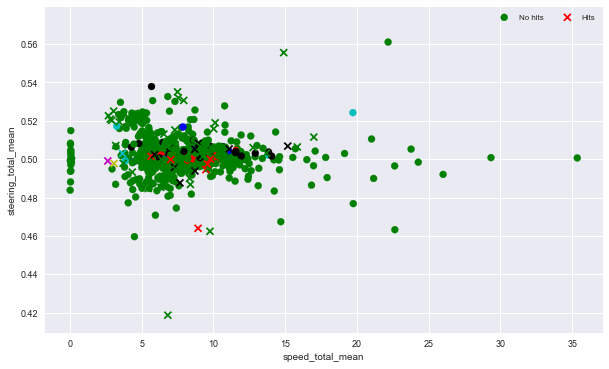

In [230]:
plt.figure(figsize=(10, 6))

#dataFrame = reactionPressBrake[reactionPressBrake.reaction_time.dt.total_seconds() < 50]

LABEL_COLOR_MAP = {0 : 'g',
                   1 : 'k',
                   2 : 'r',
                   3 : 'b',
                   4 : 'c',
                   5 : 'm',
                   6 : 'y'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in dataFrame['cluster_group']]

markerMap = np.where(dataFrame['hadCollision'] == 0, 'o', 'x')
dataFrameNoHits = dataFrame[dataFrame.hadCollision == 0]
label_color_no_hit = [LABEL_COLOR_MAP[l] for l in dataFrameNoHits['cluster_group']]
dataFrameHits = dataFrame[dataFrame.hadCollision == 1]
label_color_hit = [LABEL_COLOR_MAP[l] for l in dataFrameHits['cluster_group']]


x = 'speed_total_mean'
y = 'steering_total_mean'
c = 'cluster_group'

noHits = plt.scatter(dataFrameNoHits[x], dataFrameNoHits[y], c=label_color_no_hit, marker='o')
Hits = plt.scatter(dataFrameHits[x], dataFrameHits[y], c=label_color_hit, marker='x')

plt.xlabel(x)
plt.ylabel(y)

plt.legend(( noHits,  Hits),
           ("No hits","Hits"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)

plt.grid(True)

plt.show()

In [ ]:
## Como tomar los datos de session a partir de acá